# Data cleaning & Integration

## Libraries

In [1]:
pip install fastexcel

In [2]:
pip install xlsxwriter

In [3]:
pip install catboost

Side note: It will be useful to put all the required libraries in a requirements.txt file

In [4]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

## Global variables

In [5]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global functions

### 1. Read excel files with Polars

In [6]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Model development

### 1. File reading

In [7]:
df = polars_read_excel(PATH_DATAFRAME)

### 2. Column type

In [8]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

### 3. Data selection

In [9]:
df_input = (
    df
    #.filter(pl.col("PackagesHandled") > 0)
    .filter(pl.col("PackagingQuality").is_in(["Bad", "Good"]))
    .with_columns([
        pl.col("DateOfReport").dt.month().alias("Month"),
        pl.col("DateOfReport").dt.day().alias("Day"),
        pl.col("DateOfReport").dt.weekday().alias("Weekday"),
        (pl.col("TotalIncidents") / pl.col("PackagesHandled")).alias("TotalIncidents (%)"),
        (pl.col("AnomaliesDetected") / pl.col("PackagesHandled")).alias("AnomaliesDetected (%)")
    ])
    .sort("DateOfReport")
    .select([
        #"Month",
        #"Day",
        #"Weekday",
        "SupplierName",
        "GarmentType",
        "Material",
        "Weight",
        "ProposedUnitsPerCarton",
        "ProposedFoldingMethod",
        "ProposedLayout",
        "Size",
        "Collection",
        #"TotalIncidents (%)",
        #"AnomaliesDetected (%)",
        #"BadPackagingRate (%)",
        #"OnTimeDeliveryRate (%)",
        #"AverageCostPerIncident (€)",
        "PackagingQuality"
    ])
)

### 4. Categorical boosting

#### 4.1 Training

In [10]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Convert Polars to Pandas
df_pd = df_input.to_pandas()

# Encode target variable: Good = 1, Bad = 0
df_pd["PackagingQuality"] = df_pd["PackagingQuality"].map({"Good": 1, "Bad": 0})

# Define features and target
X = df_pd.drop(columns=["PackagingQuality"])
y = df_pd["PackagingQuality"]

# Identify categorical columns
categorical_features = X.select_dtypes(include="object").columns.tolist()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Compute dynamic class weights
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y)
class_weights = class_weights_array.tolist()

# Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Train CatBoost Classifier
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    depth=5,
    class_weights=class_weights,
    eval_metric='F1',
    early_stopping_rounds=100,
    random_seed=42,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool)

0:	learn: 0.6101165	test: 0.6099836	best: 0.6099836 (0)	total: 697ms	remaining: 23m 12s
100:	learn: 0.6143026	test: 0.6143295	best: 0.6143362 (97)	total: 39.2s	remaining: 12m 17s
200:	learn: 0.6142516	test: 0.6143470	best: 0.6156267 (148)	total: 1m 19s	remaining: 11m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6156267015
bestIteration = 148

Shrink model to first 149 iterations.


#### 4.2 Evaluating

In [11]:
# Summary report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.74      0.42     28090
           1       0.90      0.56      0.69    114071

    accuracy                           0.60    142161
   macro avg       0.60      0.65      0.55    142161
weighted avg       0.78      0.60      0.64    142161



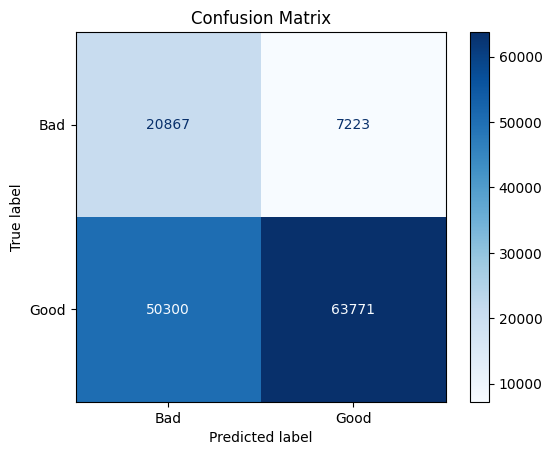

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Good"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

AUC: 0.6977


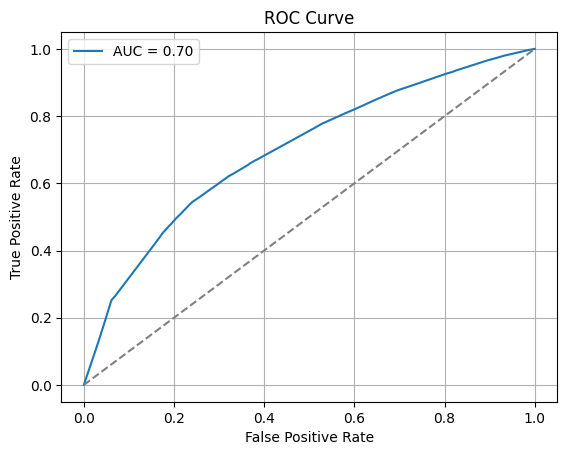

In [13]:
# Get predicted probabilities for the positive class ("Good" = 1)
y_proba = model.predict_proba(X_test)[:, 1]

# AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": model.feature_names_,
    "Importance": model.get_feature_importance()
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
0,SupplierName,62.985647
2,Material,27.470076
3,Weight,4.955707
4,ProposedUnitsPerCarton,3.649087
6,ProposedLayout,0.528584
5,ProposedFoldingMethod,0.410900
1,GarmentType,0.000000
7,Size,0.000000
8,Collection,0.000000


#### 4.3 Saving

In [15]:
# Saving the model
model.save_model("catboost_model.cbm")

# Reading the model
# model = CatBoostClassifier()
# model.load_model("catboost_model.cbm")

## Prediction development

### 1. Determine value ranges

#### 1.1 Categorical variables

In [16]:
categorical_columns = [
    "SupplierName",
    "GarmentType",
    "Material",
    "ProposedFoldingMethod",
    "ProposedLayout",
    "Size",
    "Collection"
]

# Build dictionary of distinct values
categorical_values_dict = {
    col: df_input.select(col).unique().sort(col).to_series().to_list()
    for col in categorical_columns
}

#### 1.2 Numerical variables

In [17]:
# Get min and max from df_input
min_weight = df_input.select("Weight").min().item()
max_weight = df_input.select("Weight").max().item()

min_units = df_input.select("ProposedUnitsPerCarton").min().item()
max_units = df_input.select("ProposedUnitsPerCarton").max().item()

# Create ranges dynamically
numerical_ranges = {
    "Weight": list(np.round(np.arange(min_weight, max_weight + 0.01, 0.01), 3)),
    "ProposedUnitsPerCarton": list(range(int(min_units), int(max_units) + 1))
}

### 2. Recommendation function

#### 2.1 Definition of the function

In [20]:
def recommend_best_packaging(fixed_inputs, model, top_n=1):
    # Define search space (only for variables you want to optimize)
    search_space = {
        "SupplierName": categorical_values_dict["SupplierName"],
        "ProposedUnitsPerCarton": numerical_ranges["ProposedUnitsPerCarton"],
        "ProposedFoldingMethod": categorical_values_dict["ProposedFoldingMethod"],
        "ProposedLayout": categorical_values_dict["ProposedLayout"]
    }

    # Generate Cartesian product
    keys = list(search_space.keys())
    values = list(search_space.values())
    grid_df = pd.DataFrame(itertools.product(*values), columns=keys)

    # Add fixed input columns
    for key, value in fixed_inputs.items():
        grid_df[key] = value

    # Reorder columns to match model input
    model_columns = ['SupplierName', 'GarmentType', 'Material', 'Weight',
                     'ProposedUnitsPerCarton', 'ProposedFoldingMethod',
                     'ProposedLayout', 'Size', 'Collection']
    grid_df = grid_df[model_columns]

    # Predict probabilities
    grid_df.loc[:, "prob_good"] = model.predict_proba(grid_df)[:, 1]

    # Return top N recommendations
    return grid_df.sort_values("prob_good", ascending=False).head(top_n)


#### 2.2 Test the recommendation

In [24]:
# Define the user input
fixed_inputs = {
    "GarmentType": "Shirt",
    "Material": "Cotton",
    "Weight": 1.00,
    "Size": "S",
    "Collection": "Winter"
}

# Apply the function
recommend_best_packaging(fixed_inputs, model)

,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,prob_good
677,SupplierA,Shirt,Cotton,1.0,49,Method1,LayoutC,S,Winter,0.702904
